In [ ]:
# activate R magic
%load_ext rpy2.ipython

#**Análise de Séries Temporais**

forecast - ARIMA

##**Modelando e Prevendo Séries Temporais Lineares**

Uma classe importante de modelos de séries temporais lineares é a família de modelos de **média móvel integrada (ARIMA)**, proposta por Box e Jenkins (1976). 

Ele **assume que o valor atual pode depender apenas dos valores passados** da própria série temporal ou de valores passados de algum termo de erro. Ou seja, o modelo ARIMA considera o histórico da série temporal para prever o futuro. 

##**Aspectos de interesse em Análises Temporais**

1- Análise e Modelagem da série temporal - descrever a série, verificar suas características mais relevantes e suas possíveis relações com outras séries.

2- Previsão da série temporal - a partir de valores passados da série (e talvez de outras séries também) encontrar boas previsões de curto prazo de valores futuros da série.

A dependência entre os valores da série é essencial, pois nos permite gerar previsões de valores futuros da série.

Diferentes séries possuem diferentes "graus" de previsibilidade. Por exemplo: é mais fácil prever uma série de temperaturas mensais, do que prever a taxa mensal de inflação.

Portanto, não se pode garantir que a previsão será sempre eficiente e tudo
depende das características da série estudada. 

---

##**{forecast} contém funções para desenvolver o modelo ARIMA**

In [ ]:
%%R
-
install.packages("forecast")
library("forecast")

install.packages("zoo")
library("zoo")

In [4]:
%%R
# Carregando os dados de preços de casas em uma série temporal zoo
# O parâmetro FUN indica que a série temporal é mensal (as.yearmon)
precos <- read.zoo("preco_casas.csv", sep = ",", header = TRUE, format = "%Y-%m", FUN = as.yearmon)
head(precos)
# View(precos)

Jan 1991 Feb 1991 Mar 1991 Apr 1991 May 1991 Jun 1991 
   53052    53497    52893    53677    54386    55107 


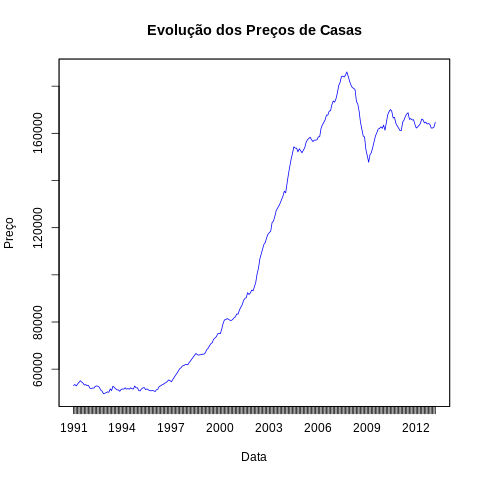

In [5]:
%%R
# Plot
# Em geral, a primeira coisa que fazemos é gerar um gráfico da série temporal e analisar seu comportamento ao longo do período analisado
plot(precos, 
     main = "Evolução dos Preços de Casas", 
     col = "blue", 
     xlab = "Data", 
     ylab = "Preço")

##**Certificar o tamanhao do período de Análise**

In [6]:
%%R
# Verificando a quantidade de períodos da série de dados
frequency(precos)

[1] 12


##**Calcular retorno da Série Temporal**

In [7]:
%%R
# Calculando o retorno simples
hp_ret <- diff(precos) / lag(precos, k = -1) * 100

---

##**Criar Modelo ARIMA**

**Identificação e estimação do modelo:**

Modelos ARIMA são modelos sofisticados, que usam as **correlações entre as observações em diversos instantes**. 

A ideia por trás dos modelos ARIMA envolve **filtros lineares** e algum conhecimento de Teoria de Sistemas.

 A identificação da estrutura do modelo é um pouco complicada. Como casos particulares dos modelos ARIMA temos os processos

- AR (Auto Regressivo) 
-  MA (Moving Average).

###**Os modelos ARIMA apresentam bons resultados quando a série é relativamente longa.**

In [ ]:
%%R
?auto.arima

Usamos a função **auto.arima** fornecida pelo pacote {forecast} para identificar o modelo ótimo e **estimar os coeficientes** em uma única etapa. 

A função possui vários argumentos além da série de retornos (hp_ret). 

Especificando stationary = TRUE, restringimos a pesquisa a **modelos estacionários**. 

De forma similar, seasonal = FALSE restringe a busca a **modelos não sazonais**. 

Além disso, selecionamos os critérios de informação de Akaike como a medida da qualidade relativa a ser usada na seleção do modelo.

In [9]:
%%R
mod <- auto.arima(hp_ret, 
                  stationary = TRUE, 
                  seasonal = FALSE, 
                  ic = "aic")

##**Visualizando o modelo**

O processo de ar2 parece encaixar melhor os dados, de acordo com os Critérios de Informação de Akaike. 

Mostra autocorrelações parciais não nulas, portanto, um processo de AR de ordem dois parece ser apropriado. 

Os dois coeficientes AR, o intercepto (que é realmente a média se o modelo contém um termo AR), e os respectivos erros padrão são mostrados.

In [10]:
%%R
mod

Series: hp_ret 
ARIMA(2,0,0) with non-zero mean 

Coefficients:
         ar1     ar2    mean
      0.2299  0.3491  0.4345
s.e.  0.0573  0.0575  0.1519

sigma^2 estimated as 1.118:  log likelihood=-390.97
AIC=789.94   AICc=790.1   BIC=804.28


##**Estimar ARIMA com argumento fixo**

##Visualizar Intervalos de Confiança

In [11]:
%%R
# Se o modelo contém coeficientes insignificantes, podemos estimar o modelo de novo usando a função arima com o argumento fixo.
confint(mod)

              2.5 %    97.5 %
ar1       0.1174881 0.3422486
ar2       0.2364347 0.4617421
intercept 0.1368785 0.7321623


##Diagnóstico do Modelo

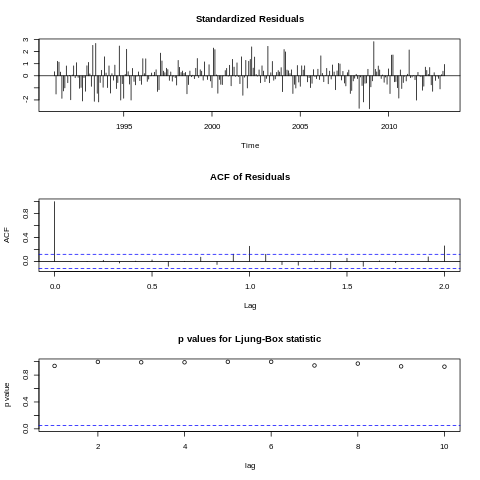

In [12]:
%%R
# Uma maneira rápida de validar o modelo é traçar diagnósticos de séries temporais usando o seguinte comando:
tsdiag(mod)

Nosso modelo parece bom:

- os resíduos padronizados não mostram clusters de volatilidade - 1°

- não há autocorrelações significativas entre os resíduos de acordo com o gráfico ACF - 2°

- o teste Ljung-Box para autocorrelação mostra altos valores de p, assim a **hipótese nula** de independência Resíduos **não pode ser rejeitada.** - 3° 


##Linha preta é Série Temporal, a linha vermelha são os dados que representam o modelo que identifica o padrão da Série. 

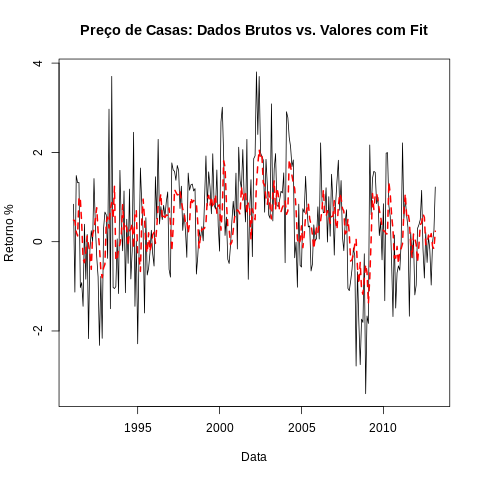

In [13]:
%%R
# Para avaliar o quão bem o modelo representa os dados da amostra, podemos traçar os retornos mensais brutos 
# (a linha sólida preta fina) versus os valores ajustados (a linha pontilhada vermelha tracejada).
plot(mod$x, lty = 1, main = "Preço de Casas: Dados Brutos vs. Valores com Fit", ylab = "Retorno %", xlab = "Data")
lines(fitted(mod), lty = 2,lwd = 2, col = "red")

In [14]:
%%R
# Calculando outras medidas de acurácia
accuracy(mod)

                      ME     RMSE       MAE  MPE MAPE      MASE         ACF1
Training set 0.001203096 1.051422 0.8059929 -Inf  Inf 0.7154503 -0.004848183


##**Realizar Previsões p/ 3 períodos futuros**

In [15]:
%%R
# Prevendo o retorno mensal 3 meses a frente
# Para traçar a previsão com erros padrão, podemos usar o seguinte comando:
predict(mod,
        n.ahead = 3)

$pred
           Apr       May       Jun
2013 0.5490544 0.7367277 0.5439708

$se
          Apr      May      Jun
2013 1.057401 1.084978 1.165247



## Assim, esperamos um ligeiro aumento nos preços médios das casas nos próximos três meses, mas com um erro padrão elevado de cerca de 1%. 

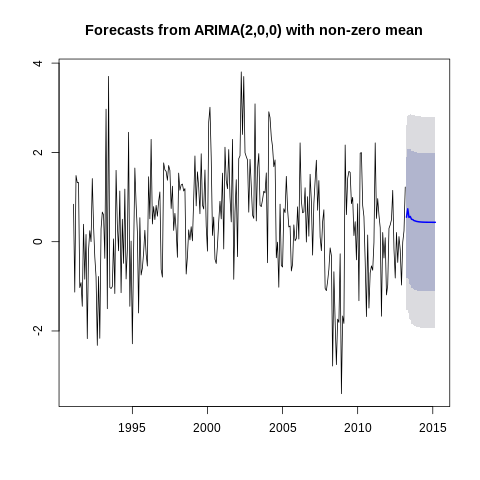

In [17]:
%%R
# Plot
plot(forecast(mod))
